In [1]:
# 全局设置
import sys
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS
fd = QS.FactorDB.FactorTools

HDB = QS.FactorDB.HDF5DB(config_file="../config/HDF5DBConfig.json").connect();

RDB = QS.RiskDB.HDF5FRDB(config_file="../config/HDF5FRDBConfig.json").connect();

# Brinson 模型

In [2]:
# Brinson 模型: 以上证 50 指数持仓作为示例投资组合, 基准为 沪深 300
StartDT, EndDT = dt.datetime(2017, 1, 1), dt.datetime(2019, 4, 30)# 数据起止时间
FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
DTs = FT.getDateTime(ifactor_name="close", start_dt=StartDT, end_dt=EndDT)
IDs = FT.getID(ifactor_name="close")

# 再平衡时点序列
BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末

# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_adj_backward_nafilled"), factor_names=["close"], args={})
CFT.addFactors(factor_table=HDB.getTable("stock_cn_info"), factor_names=["if_listed"], args={})
CFT.addFactors(factor_table=HDB.getTable("stock_cn_factor_barra_descriptor"), factor_names=["Industry"], args={})
CFT.addFactors(factor_table=HDB.getTable("stock_cn_index_component"), factor_names=["hs_300_weight", "sh_50_weight"], args={})

CFT.setDateTime(DTs)
CFT.setID(IDs)

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# --------回测模块--------
iModule = QS.BackTest.PerformanceAnalysis.BrinsonModel(factor_table=CFT, name="Brinson模型")
iModule.Args["策略组合"] = "sh_50_weight"
iModule.Args["基准组合"] = "hs_300_weight"
iModule.Args["资产类别"] = "Industry"
iModule.Args["价格因子"] = "close"
iModule.Args["计算时点"] = BalanceDTs
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs, subprocess_num=0)

# 查看结果
display(Model)

==========历史回测==========
1. 初始化


  0% (0 of 566) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

耗时 : 8.61
2. 循环计算


100% (566 of 566) |######################| Elapsed Time: 0:01:17 Time:  0:01:17


耗时 : 77.61
3. 结果生成
耗时 : 0.21
总耗时 : 86.42


,策略组合收益,基准组合收益,主动资产配置组合收益,主动个券选择组合收益,主动资产配置超额收益,主动个券选择超额收益,交互作用超额收益,总超额收益
现金,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Banks,6.58%,3.71%,6.94%,3.52%,3.23%,-0.19%,-0.17%,2.87%
Real Estate,0.87%,1.29%,0.69%,1.71%,-0.59%,0.42%,-0.25%,-0.42%
Industrial Conglomerates,0.00%,-0.08%,0.00%,0.00%,0.08%,0.08%,-0.08%,0.08%
Health,0.61%,1.29%,0.30%,1.58%,-1.00%,0.29%,0.03%,-0.68%
Commercial and Professional Services,0.00%,-0.48%,0.00%,0.00%,0.48%,0.48%,-0.48%,0.48%
Hotels Restaurants and Leisure,0.32%,0.58%,0.27%,0.25%,-0.31%,-0.32%,0.37%,-0.25%
Industrial Machinery,0.00%,0.49%,0.44%,-0.04%,-0.05%,-0.53%,0.09%,-0.49%
Construction and Engineering,-0.37%,-0.33%,-0.59%,-0.20%,-0.26%,0.14%,0.08%,-0.04%
Construction Materials,0.27%,0.42%,0.24%,0.25%,-0.18%,-0.16%,0.20%,-0.15%


# 因子模拟组合模型

==========历史回测==========
1. 初始化
耗时 : 0.59
2. 循环计算


100% (43 of 43) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


耗时 : 9.02
3. 结果生成
耗时 : 0.08
总耗时 : 9.69


,因子暴露,风险调整的因子暴露,风险贡献,风险贡献占比,收益贡献
Beta,0.0103,0.0002,0.01%,0.0282,0.00%
BookToPrice,0.0009,0.0000,0.00%,0.0003,0.00%
EarningsYield,-0.0057,-0.0000,-0.00%,-0.0005,-0.01%
Growth,-0.0007,-0.0000,0.00%,0.0000,-0.00%
Leverage,0.0029,0.0000,0.00%,0.0001,-0.00%
Liquidity,-0.0154,-0.0002,-0.00%,-0.0061,0.01%
Momentum,-0.0196,-0.0002,0.01%,0.0316,0.00%
NonlinearSize,0.0001,0.0000,-0.00%,-0.0000,0.00%
ResidualVolatility,-0.0198,-0.0002,-0.01%,-0.0382,0.02%
Size,-0.0739,-0.0008,0.03%,0.1042,-0.04%

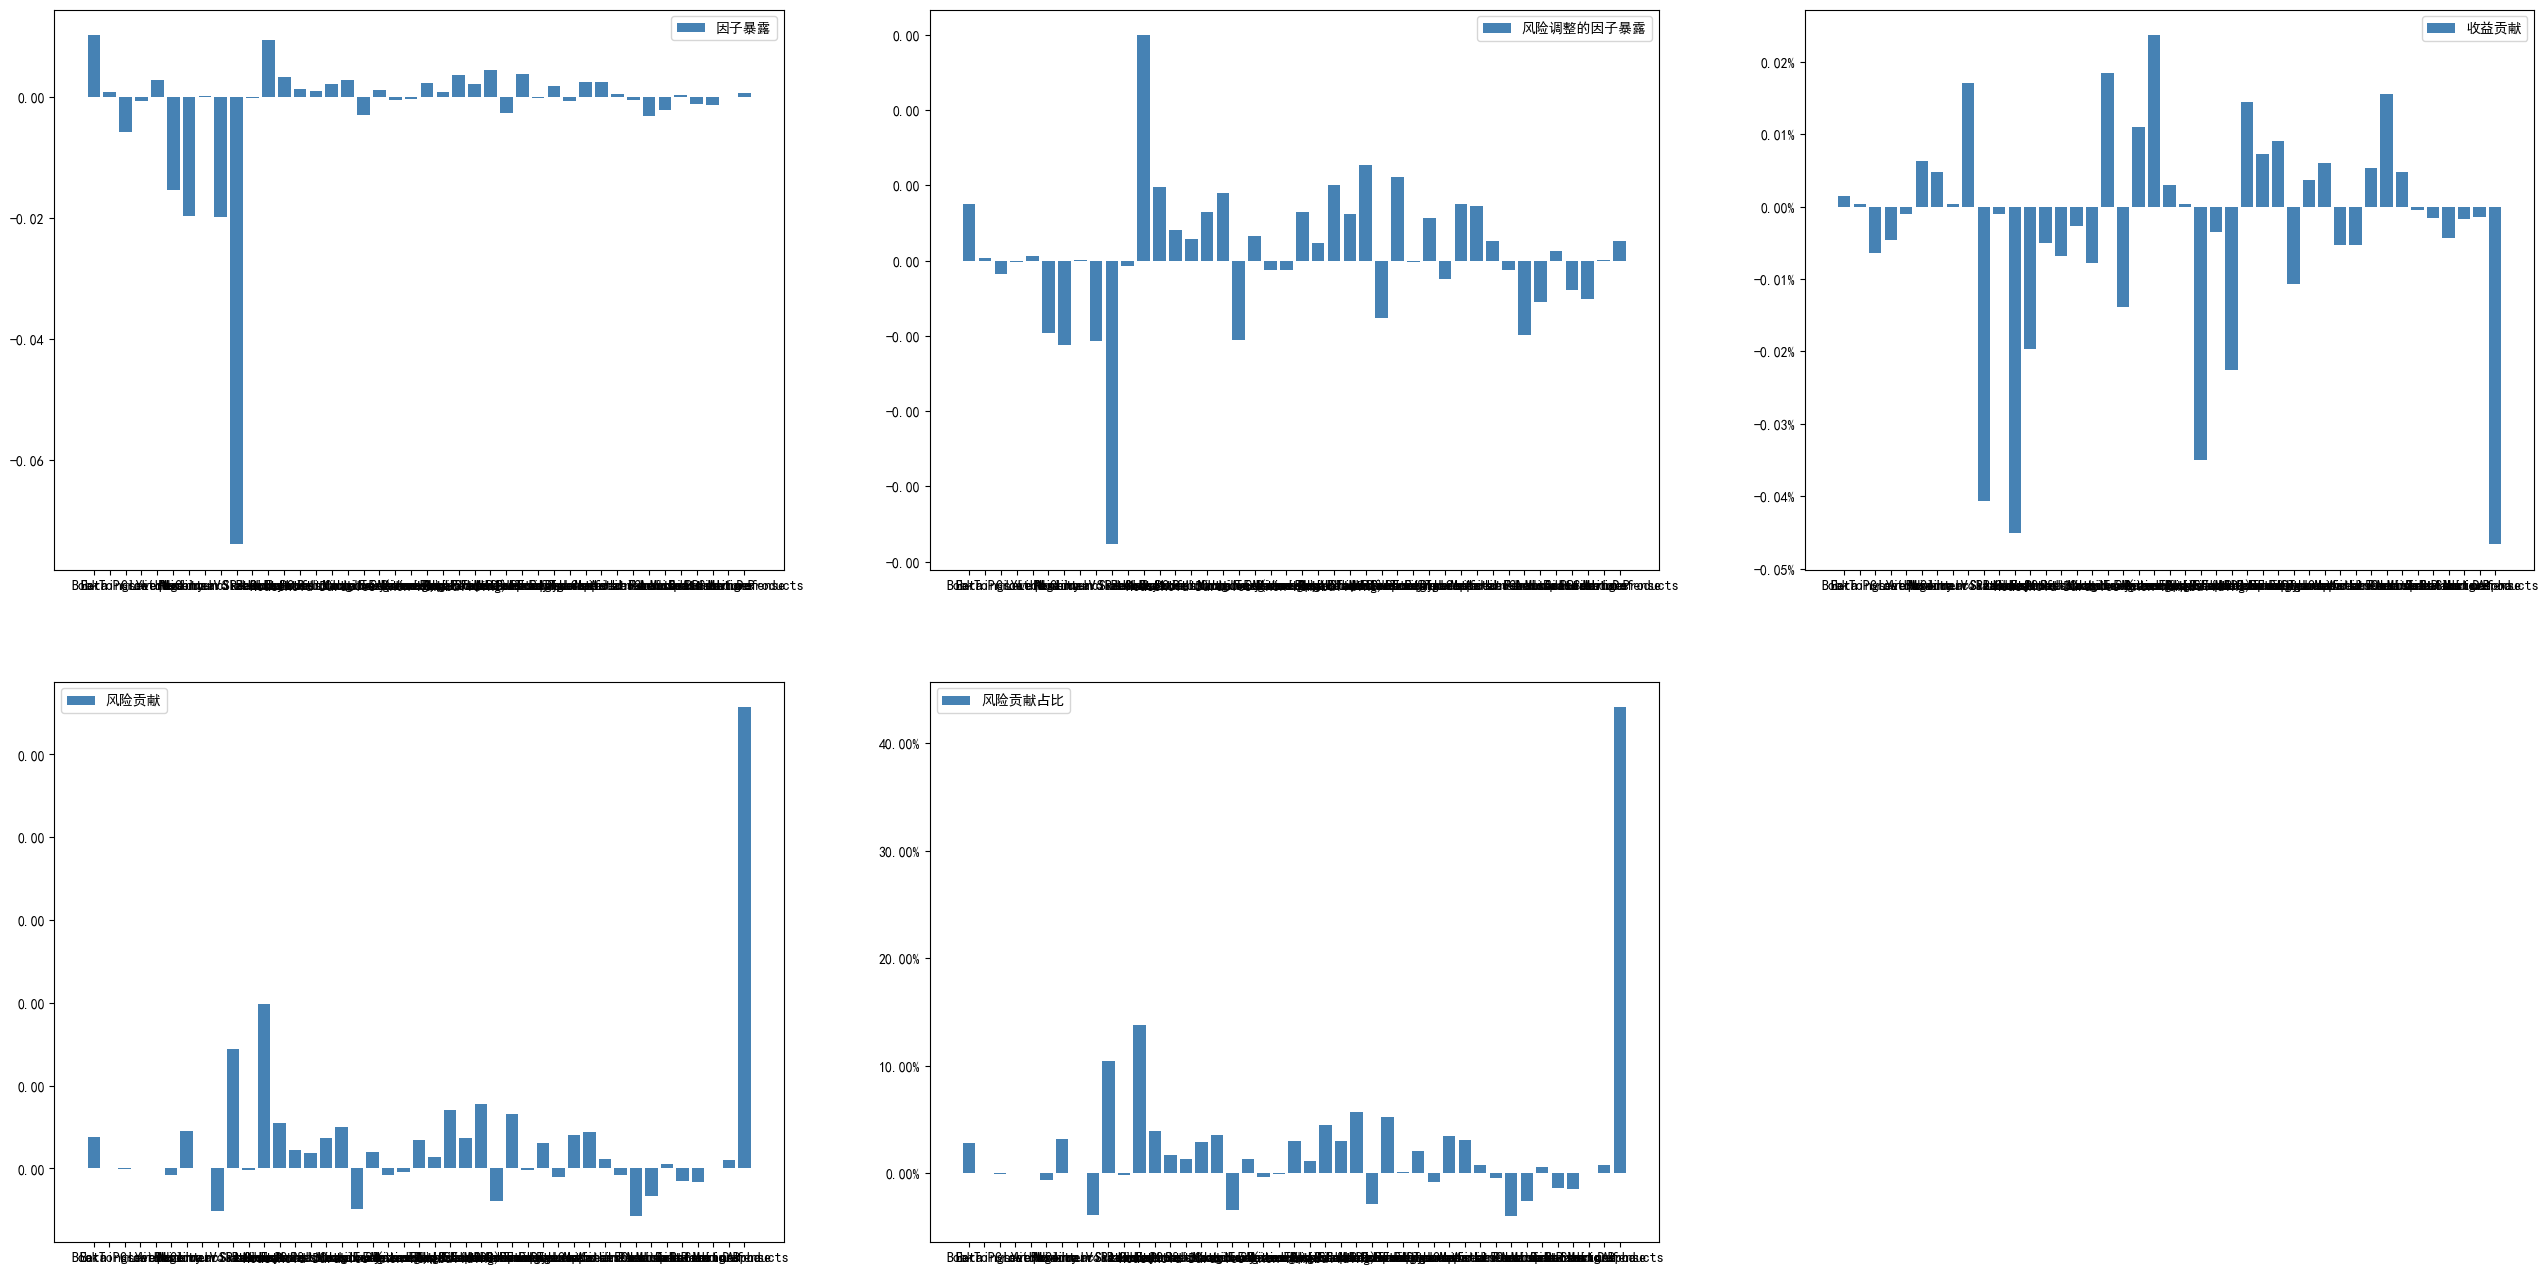

In [2]:
# 因子模拟组合模型: 目标组合是随机组合，基准组合是等权组合
StartDT, EndDT = dt.datetime(2018, 7, 31), dt.datetime(2018, 9, 28)# 数据起止时间
FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
DTs = FT.getDateTime(ifactor_name="close", start_dt=StartDT, end_dt=EndDT)

RT = RDB.getTable("BarraRiskData")# 风险数据表
IDs = RT.getID()

# 再平衡时点序列
BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末

# 创建自定义因子表
CFT = QS.FactorDB.CustomFT("CFT")
FT = HDB.getTable("stock_cn_factor_barra")
AttrFactors = FT.FactorNames
CFT.addFactors(factor_table=FT, factor_names=AttrFactors, args={})
CFT.addFactors(factor_table=HDB.getTable("stock_cn_factor_barra_descriptor"), factor_names=["Industry"], args={})

FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
CFT.addFactors(factor_table=FT, factor_names=["close"], args={})
CFT.addFactors(factor_table=HDB.getTable("stock_cn_info"), factor_names=["if_listed"], args={})

np.random.seed(0)
TargetPortfolio = QS.FactorDB.DataFactor(name="target", data=pd.DataFrame(np.random.rand(len(BalanceDTs), len(IDs)), index=BalanceDTs, columns=IDs))
np.random.seed(None)
BenchmarkPortfolio = QS.FactorDB.DataFactor(name="benchmark", data=pd.DataFrame(1/len(IDs), index=BalanceDTs, columns=IDs))
CFT.addFactors(factor_list=[TargetPortfolio, BenchmarkPortfolio])

CFT.setDateTime(DTs)
CFT.setID(IDs)

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# --------回测模块--------
iModule = QS.BackTest.PerformanceAnalysis.FMPModel(factor_table=CFT, name="FMP模型")
iModule.Args["策略组合"] = "target"
iModule.Args["基准组合"] = "benchmark"
iModule.Args["特征因子"] = AttrFactors
iModule.Args["行业因子"] = "Industry"
iModule.Args["价格因子"] = "close"
iModule.Args["风险表"] = RT
iModule.Args["计算时点"] = BalanceDTs
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs, subprocess_num=0)

# 查看结果
display(Model)